# An Analysis of the Impact of COVID-19 on Crime in College Park, MD

### By Moses Kang, Andrew Xu, and Murat Ablimit

## Introduction

The COVID-19 pandemic has truly served as a transformative historical event in the 21st century. The pandemic has led to the dramatic loss of human life around the world. Additionally, many aspects of life and human behavior have been forced to change due to the restrictions and limitations COVID-19 has brought forth. The food service industry, retail, educational institutions, healthcare, and much more have all been challenged and threatened at a scale we have never seen before. Periodic lockdowns and enforced quarantines have resulted in loss of income, economic assests, and employment in general for millions. When livelihoods become challenged and endangered to the extent like they have in this pandemic, immense feelings of desperation and hopelessness become frequent. For this reason, it becomes worthwhile to hypothesize if this pandemic and all of its challenges have impacted criminal activitiy. As a result, our null hypothesis will be that this pandemic have not impacted criminal activity at all.    

In this project, we will attempt to present and uncover a correlation between the pandemic and criminal activity in the city of College Park, Maryland. We will do so by analyzing crime data, provided by the University of Maryland College Park Police Department (UMPD), between two time periods. The first time period being the entire year of 2019 to March 2020 (pre-pandemic), and the second time period being April of 2020 onwards (pandemic).     

The following sections of this project will serve as a guide on the collection of our data (Data Collection/Scraping), the cleaning of the data (Data Processing), the visualization of the data (Data Visualization), and the in-depth analysis of the data (Analysis, Hypothesis Testing, and Machine Learning).

## Data Collection

To collect the neccessary data for this project, we will scrape the University of Maryland, College Park Police Department website: http://www.umpd.umd.edu/stats/incident_logs.cfm. 

Because the website organizes the data by year and month, we will use python's requests module to retrieve the HTML that corresponds to the page for each month in a year. Afterwards, we will use the BeautifulSoup library to to find the html for the table that contains the data for each month. We will then concatenate each month's data to make a dataframe for each year. Because we are comparing crime between pre-pandemic and during the pandemic, we will only use the data from 2019 to 2020. Yearly data is then stored in a dictionary, with the year (2019 or 2020) acting as the key and the corresponding dataframes for each year serving as the values.  



In [1]:
import requests
import pandas as pd, numpy as np, sklearn as sk, matplotlib.pyplot as plt
from sklearn import linear_model
from bs4 import BeautifulSoup
from scipy.stats import ttest_rel
import sys
!{sys.executable} -m pip install lxml html5lib

In [2]:
years = ['2019','2020']

#Dictionary that will hold the data
data_raw = {}

#Loops for each year
for year in years:
    
    #This will hold each yearly data set
    df = pd.DataFrame()
    
    #Loops for each month
    for m in range(1,13):
        page = requests.get('http://www.umpd.umd.edu/stats/incident_logs.cfm?year='+year+"&month="+str(m))
        content = BeautifulSoup(page.content)
        table = content.find('table')
        t = pd.read_html(str(table))
        d=pd.concat(t)
        df = pd.concat([df,d])
        
    #adds the yearly data to the main dictionary
    data_raw[year] = df
    
data_raw['2019'].head()

,UMPD CASENUMBER,OCCURRED DATE TIMELOCATION,REPORT DATE TIME,TYPE,DISPOSITION,Unnamed: 5
0,2019-00000001,01/01/19 00:01,01/01/19 00:01,Fireworks Complaint,Arrest,NaN
1,2019-00000001,4300 block of Knox Rd,4300 block of Knox Rd,4300 block of Knox Rd,4300 block of Knox Rd,4300 block of Knox Rd
2,2019-00000009,01/01/19 01:20,01/01/19 01:20,DWI/DUI,Arrest,NaN
3,2019-00000009,8300 block of Baltimore Ave,8300 block of Baltimore Ave,8300 block of Baltimore Ave,8300 block of Baltimore Ave,8300 block of Baltimore Ave
4,2019-00000011,01/01/19 01:28,01/01/19 01:28,DWI/DUI,Arrest,NaN


## Data Processing

As can be seen above, data scraping does not give ideally formatted or "clean" data, due to how the website and html stores data. The main problem is that each case is listed twice in the dataframe, with the location of the case being listed 5 times in the 2nd entry and there being a column named "Unnamed: 5". Additonally, the way we have divided our data in terms of year does not really make sense either. We have two dataframes for crime data for 2019 and 2020, since we want to be comparing data pre-pandemic and during the pandemic, it makes more sense if we change these two dataframes so that they reflect the actual periods of time that constitute life before the pandemic and life during the pandemic. For the purposes of this project, we are going to consider 2019 to before March 2020 as pre-pandemic and March 2020 onwards as the pandemic. In this section we will tidy up the data, reformat it for our convenience, and deal with all NaN or missing values.

In [3]:
data_cleaned = {}

for year in years:
    i = 0
    df_new = pd.DataFrame(columns = ['CaseNumber', 'OccuredDateTime','ReportDateTime', 'Type', 'Disposition', 'Location'])

    while i < len(data_raw[year]):
    
        df_new = df_new.append({'CaseNumber' : data_raw[year].iloc[i]['UMPD CASENUMBER'],
                                'OccuredDateTime' : data_raw[year].iloc[i]['OCCURRED DATE TIMELOCATION'],
                                'ReportDateTime' : data_raw[year].iloc[i]['REPORT DATE TIME'],
                                'Type' : data_raw[year].iloc[i]['TYPE'],
                                'Disposition' : data_raw[year].iloc[i]['DISPOSITION'],
                                'Location' : data_raw[year].iloc[i+1]['OCCURRED DATE TIMELOCATION']}, ignore_index=True)
        i+=2
    data_cleaned[year] = df_new
    

data_cleaned['2019'].head()

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location
0,2019-00000001,01/01/19 00:01,01/01/19 00:01,Fireworks Complaint,Arrest,4300 block of Knox Rd
1,2019-00000009,01/01/19 01:20,01/01/19 01:20,DWI/DUI,Arrest,8300 block of Baltimore Ave
2,2019-00000011,01/01/19 01:28,01/01/19 01:28,DWI/DUI,Arrest,7400 block of Baltimore Ave
3,2019-00000203,12/28/18 17:00,01/02/19 11:34,Vandalism,CBE,7500 block of Calvert Service Ln
4,2019-00000312,01/02/19 23:04,01/02/19 23:04,CDS Violation,Arrest,Metzerott Rd


In summary, instead of modifying each dataframe, we opted to create a new dataframe for each year, as this approach was simpler to code. Essentially, we have removed every other row and replaced the unnamed column with the location of the incident, as well as renaming each column header.

After this data cleaning process, two more issues need solving. The first is that we now need to split this clean data into the appropriate time periods, pre-pandemic and pandemic, for our analysis. The second is that we need to deal with any NaN values. The below code will accomplish this.

As described before, pre-pandemic will constitute 2019 to March 2020 and the pandemic will constitute April 2020 onwards. Therefore, we need to split the 2020 dataframe in the data_cleaned dictionary at the first case that occured in April. The pre-pandemic time period will be spread out over two dataframes, **pre_pandemic_2019** and **pre_pandemic_2020**. All cases that occured in 2020 but before April will be part of the **pre_pandemic_2020** dataframe, and all cases that occured April onwards will be part of the **pandemic_2020** dataframe. The **pre_pandemic_2019** dataframe will just contain all cases that occured in the year of 2019. 

For NaN values in columns like *Location*, we will replace all instances of NaN with "Unknown". 

Note: Due to certain efficiency constraints of the geolocation library we would like to use for the visualization section of this project, we will sample 10% of the cases for each time period dataframe. 

In [4]:
data_to_analyze = {} #store the final processed data into this dictionary

for index, row in data_cleaned['2020'].iterrows():
    if row['OccuredDateTime'].startswith('04'): #finds the first case that occured in March of 2020
        data_to_analyze['pre_pandemic_2019'] = pd.DataFrame(data_cleaned['2019']).sample(frac = 0.1)
        #dataframe that has cases before April 2020
        data_to_analyze['pre_pandemic_2020'] = pd.DataFrame(data_cleaned['2020'].iloc[:index,:]).sample(frac = 0.1) 
        #dataframe that has cases from April 2020 onwards
        data_to_analyze['pandemic_2020'] = pd.DataFrame(data_cleaned['2020'].iloc[index + 1:,:]).sample(frac = 0.1)
        break
        
data_to_analyze['pre_pandemic_2019']['Location'].fillna("Unknown", inplace=True)
data_to_analyze['pre_pandemic_2020']['Location'].fillna("Unknown", inplace=True)
data_to_analyze['pandemic_2020']['Location'].fillna("Unknown", inplace=True)

data_to_analyze['pre_pandemic_2019']

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location
163,2019-00008347,02/12/19 13:50,02/12/19 14:18,Suspicious Activity (Title IX Related),CBE,7700 block of Alumni Dr
198,2019-00009319,02/17/19 01:54,02/17/19 01:54,DWI/DUI,Arrest,Guilford Rd
1671,2019-00066615,11/13/19 14:15,11/13/19 19:22,Theft,Arrest,7000 block of Preinkert Dr
1854,2019-00075810,12/21/19 00:34,12/21/19 00:34,DWI/DUI,Arrest,Campus Dr
1284,2019-00054361,09/17/19 22:15,09/17/19 22:15,Assist Other Agency,CBE,"Oakland, Oakland Hall at 3912 Denton Service Ln"
...,...,...,...,...,...,...
872,2019-00035544,06/25/19 00:15,06/25/19 00:52,Injured/Sick Person,CBE,Baltimore at 7497 Calvert Service Ln
1606,2019-00064220,11/02/19 17:34,11/02/19 17:34,Check on the Welfare,CBE,"Oakland, Oakland Hall at 3912 Denton Service Ln"
1346,2019-00056248,09/26/19 16:53,09/26/19 16:53,Vandalism,Active/Pending,8200 block of Boteler Ln
1482,2019-00060146,10/12/19 20:37,10/12/19 20:37,CDS Violation,CBE,4000 block of Stadium Dr


In [5]:
data_to_analyze['pre_pandemic_2020']

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location
128,2020-00009144,02/04/20 02:12,02/04/20 02:12,CDS Violation,Arrest,4300 block of Campus Dr
129,2020-00009210,02/04/20 12:00,02/04/20 12:25,Injured/Sick Person,CBE,Fieldhouse Dr
292,2020-00016768,03/04/20 22:47,03/04/20 22:47,Emergency Petition,CBE,7700 block of Alumni Dr
134,2020-00009485,02/05/20 16:00,02/05/20 16:03,Injured/Sick Person,CBE,4300 block of Stadium Dr
287,2020-00016632,03/03/20 18:45,03/04/20 10:50,Burglary,Arrest,8000 block of Regents Dr
250,2020-00015198,02/28/20 08:13,02/28/20 08:13,Trespassing,CBE,4300 block of Knox Rd
336,2020-00018528,03/11/20 20:50,03/11/20 23:31,Police Information,CBE,7500 block of Baltimore Ave
243,2020-00014981,02/26/20 19:45,02/27/20 10:37,Theft,Investigation Pending,3900 block of Campus Dr
323,2020-00017722,03/08/20 23:30,03/08/20 23:30,DWI/DUI,Arrest,4400 block of Knox Rd
89,2020-00007551,01/29/20 00:28,01/29/20 00:28,Alcohol Violation,Arrest,College Ave


In [6]:
data_to_analyze['pandemic_2020']

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location
513,2020-00056687,08/17/20 09:23,08/17/20 09:23,Damaged Property,CBE,7000 block of Preinkert Dr
613,2020-00065065,09/13/20 22:41,09/13/20 22:41,DWI/DUI,Arrest,Berwyn House Rd
723,2020-00072796,10/11/20 00:03,10/11/20 00:03,DWI/DUI,Arrest,University Blvd
677,2020-00069867,09/30/20 19:30,09/30/20 21:36,Fraud,Investigation Pending,8400 block of Boteler Ln
549,2020-00060123,08/28/20 22:30,08/28/20 22:40,Emergency Petition,CBE,6900 block of Preinkert Dr
857,2020-00082701,11/17/20 07:00,11/18/20 16:44,Theft from Auto,Investigation Pending,3800 block of Golf Course Rd
884,2020-00086679,11/22/20 12:00,12/03/20 10:53,Theft,Active/Pending,3900 block of Campus Dr
446,2020-00040682,06/08/20 17:00,06/09/20 13:31,Burglary,Investigation Pending,4100 block of Campus Dr
783,2020-00077233,10/28/20 01:45,10/28/20 01:45,Traffic Arrest,Arrest,Severn at 5245 Greenbelt Rd
671,2020-00069200,09/28/20 13:48,09/28/20 13:48,Trespassing,Arrest,4300 block of Knox Rd


## Data Visualization

In this section, we will be visualizing the College Park crime data by generating interactive maps provided by the Folium library. 

For more information on Folium and its documentation: https://python-visualization.github.io/folium/quickstart.html

Before we can actually generate these interactive maps, we must add latitude and longitude coordinates for each case in our pre-pandemic and pandemic dataframes. We will first need to add latitude and longitude columns to each of our dataframes. To obtain these coordinates, we will need to formulate a complete College Park address for the location of each case and then determine the coordinates of this address by using geopy (https://pypi.org/project/geopy/).   

To make sure we provide a complete and appropriate address that geopy can identiy and locate, we must format certain types of case locations.

1. "Unknown locations": We will just assign an arbitary latitude and longitude pair that is within the College Park Area. 


2. Locations at "Golf Course Rd": For some reason geopy cannot locate Golf Course Rd, the road next to the University of Maryland Golf Course. To make sure that any case with a location at "Golf Course Rd" is given proper coordinates, we will manually assign coordinates for cases at this location with the coordinates given by Google Maps. 


3. Blocks locations such as "4000 block of Stadium Dr": Geopy has trouble parsing an address with any extraneous information such as "block of" so we will reformat such locations to "block_number street_name".


4. Campus building locations such as "Severn at 5245 Greenbelt Rd": Geopy also has trouble properly locating locations with this format so we will ignore building names and just focus on the actual street number and street name. 

In [7]:
!pip install geopy
import geopy
from geopy.geocoders import Nominatim


#Set default np.nan values for Latitude and Longtitude
data_to_analyze['pre_pandemic_2019']["Latitude"] = np.nan 
data_to_analyze['pre_pandemic_2019']["Longitude"] = np.nan
data_to_analyze['pre_pandemic_2020']["Latitude"] = np.nan 
data_to_analyze['pre_pandemic_2020']["Longitude"] = np.nan
data_to_analyze['pandemic_2020']["Latitude"] = np.nan
data_to_analyze['pandemic_2020']["Longitude"] = np.nan
                                           
found_coord = {} #Keeps track of repeating addresses


for df in data_to_analyze.values(): #For each time period dataframe
    for idx in df.index:
        address = df.at[idx,"Location"]
        
        if address == "Unknown": # if address/location is unknown give arbitrary coordinate points for College Park
            df.at[idx,"Latitude"] =  38.980666
            df.at[idx,"Longitude"] =  -76.9369189
            continue
           
        if not('Golf Course Rd' not in address):
            df.at[idx,"Latitude"] = 38.991081
            df.at[idx,"Longitude"] = -76.953156
            continue
            
                
        if address in found_coord: #check if we have already found coordinates for this location
            df.at[idx,"Latitude"] = found_coord[address][0] 
            df.at[idx,"Longitude"] = found_coord[address][1] 
            continue

        if not("block of" not in address): #block location case
            lst = address.split()
            address = lst[0]
            index_after_of = 3
            for i in range(3, len(lst)): #reformats address to include block number and street name
                address += " " + lst[i]
                
        if not(" at " not in address): #building location case
            lst = address.split()
            address = ""
            index_after_of = lst.index('at')
            #reformats address to just be equal to the street address of the building
            for i in range(index_after_of + 1, len(lst)): 
                address += " " + lst[i]
        
        
        address = address + ", College Park, MD 20740" #ensure address comes from College Park
        
        
        geolocator = Nominatim(user_agent="murat") #to use Nominatim you must provide a user_agent
        location = geolocator.geocode(address)
        
        if location is not None: #makes sure we only edit cases that return valid coordinates
            df.at[idx,"Latitude"] = location.latitude
            df.at[idx,"Longitude"] = location.longitude
            found_coord[address] =[location.latitude, location.longitude]
        
       

    
data_to_analyze['pandemic_2020']

    

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location,Latitude,Longitude
513,2020-00056687,08/17/20 09:23,08/17/20 09:23,Damaged Property,CBE,7000 block of Preinkert Dr,38.983766,-76.945139
613,2020-00065065,09/13/20 22:41,09/13/20 22:41,DWI/DUI,Arrest,Berwyn House Rd,38.991246,-76.930875
723,2020-00072796,10/11/20 00:03,10/11/20 00:03,DWI/DUI,Arrest,University Blvd,38.992030,-76.946103
677,2020-00069867,09/30/20 19:30,09/30/20 21:36,Fraud,Investigation Pending,8400 block of Boteler Ln,39.002114,-76.943004
549,2020-00060123,08/28/20 22:30,08/28/20 22:40,Emergency Petition,CBE,6900 block of Preinkert Dr,38.981540,-76.945098
857,2020-00082701,11/17/20 07:00,11/18/20 16:44,Theft from Auto,Investigation Pending,3800 block of Golf Course Rd,38.991081,-76.953156
884,2020-00086679,11/22/20 12:00,12/03/20 10:53,Theft,Active/Pending,3900 block of Campus Dr,38.988272,-76.934257
446,2020-00040682,06/08/20 17:00,06/09/20 13:31,Burglary,Investigation Pending,4100 block of Campus Dr,38.988272,-76.934257
783,2020-00077233,10/28/20 01:45,10/28/20 01:45,Traffic Arrest,Arrest,Severn at 5245 Greenbelt Rd,38.995834,-76.922052
671,2020-00069200,09/28/20 13:48,09/28/20 13:48,Trespassing,Arrest,4300 block of Knox Rd,38.981487,-76.942384


In [29]:
data_to_analyze['pre_pandemic_2020']

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location,Latitude,Longitude
128,2020-00009144,02/04/20 02:12,02/04/20 02:12,CDS Violation,Arrest,4300 block of Campus Dr,38.988272,-76.934257
129,2020-00009210,02/04/20 12:00,02/04/20 12:25,Injured/Sick Person,CBE,Fieldhouse Dr,38.989379,-76.943283
292,2020-00016768,03/04/20 22:47,03/04/20 22:47,Emergency Petition,CBE,7700 block of Alumni Dr,38.990237,-76.949424
134,2020-00009485,02/05/20 16:00,02/05/20 16:03,Injured/Sick Person,CBE,4300 block of Stadium Dr,38.990158,-76.939183
287,2020-00016632,03/03/20 18:45,03/04/20 10:50,Burglary,Arrest,8000 block of Regents Dr,38.988170,-76.940909
250,2020-00015198,02/28/20 08:13,02/28/20 08:13,Trespassing,CBE,4300 block of Knox Rd,38.981487,-76.942384
336,2020-00018528,03/11/20 20:50,03/11/20 23:31,Police Information,CBE,7500 block of Baltimore Ave,38.999216,-76.931392
243,2020-00014981,02/26/20 19:45,02/27/20 10:37,Theft,Investigation Pending,3900 block of Campus Dr,38.988272,-76.934257
323,2020-00017722,03/08/20 23:30,03/08/20 23:30,DWI/DUI,Arrest,4400 block of Knox Rd,38.980916,-76.937637
89,2020-00007551,01/29/20 00:28,01/29/20 00:28,Alcohol Violation,Arrest,College Ave,38.981119,-76.933341


In [34]:
data_to_analyze['pre_pandemic_2019']

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location,Latitude,Longitude
163,2019-00008347,02/12/19 13:50,02/12/19 14:18,Suspicious Activity (Title IX Related),CBE,7700 block of Alumni Dr,38.990237,-76.949424
198,2019-00009319,02/17/19 01:54,02/17/19 01:54,DWI/DUI,Arrest,Guilford Rd,38.977178,-76.934031
1671,2019-00066615,11/13/19 14:15,11/13/19 19:22,Theft,Arrest,7000 block of Preinkert Dr,38.983766,-76.945139
1854,2019-00075810,12/21/19 00:34,12/21/19 00:34,DWI/DUI,Arrest,Campus Dr,38.988272,-76.934257
1284,2019-00054361,09/17/19 22:15,09/17/19 22:15,Assist Other Agency,CBE,"Oakland, Oakland Hall at 3912 Denton Service Ln",38.993839,-76.949288
...,...,...,...,...,...,...,...,...
872,2019-00035544,06/25/19 00:15,06/25/19 00:52,Injured/Sick Person,CBE,Baltimore at 7497 Calvert Service Ln,38.982174,-76.942216
1606,2019-00064220,11/02/19 17:34,11/02/19 17:34,Check on the Welfare,CBE,"Oakland, Oakland Hall at 3912 Denton Service Ln",38.993839,-76.949288
1346,2019-00056248,09/26/19 16:53,09/26/19 16:53,Vandalism,Active/Pending,8200 block of Boteler Ln,39.001787,-76.942173
1482,2019-00060146,10/12/19 20:37,10/12/19 20:37,CDS Violation,CBE,4000 block of Stadium Dr,38.992439,-76.947428


After finding the latitude and longitude coordinates for all of the cases, now we can use folium to map and visualize the data for each dataframe. Let's first generate a map of the general College Park area. 

In [38]:
!pip install folium
import folium
import matplotlib.pyplot as plt

map_osm = folium.Map(location=[38.9897, -76.9378], zoom_start=14)
map_osm

To make our maps more descriptive we will need to use marker popups which will represent an individual case. To generate these popups for each of the maps we will need to create an html statement as seen in the following function. 

In [24]:
#Takes in a single row of a dataframe, outputs an html statement out of the contents of the row
def popup_as_html(row):
    html = '<center><p>' + \
            str(row['CaseNumber']) + \
            '</br>' + \
            'Type: ' + str(row['Type']) + \
            '</br>' + \
            'Disposition: ' + str(row['Disposition']) + \
            '</p></center>'
    return html

Now we can generate our map visualizations, alongside each map for each time period will be code to generate a list of the top 10 types of cases that were filed. 

### Map 1: Pre-Pandemic 2019 Time Period

In [43]:
map1 = folium.Map(location=[38.9897, -76.9378], zoom_start=14)
for idx, row in data_to_analyze['pre_pandemic_2019'].iterrows(): #each case is labeled with a blue marker
    folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_as_html(row),
            icon=folium.Icon(color='blue', icon='warning', prefix='fa')
        ).add_to(map1)

map1

Code to generate a list of the top ten types of cases across the 2019 pre-pandemic period. 

In [44]:
types = sorted(data_to_analyze['pre_pandemic_2019']["Type"].unique()) #Get all unique case types for this time period
types_with_counts = [] #Each case type's count will be stored in this list

temp_df = data_to_analyze['pre_pandemic_2019'].copy() 

i = 0
for ele in types: #Computes frequency for each case type by grouping in the temp_df 
    #Count by the attribute type, fill in that value in all columns, then store as a tuple into list
    types_with_counts.append((ele, temp_df.groupby('Type').count()['Disposition'][0:].values[i])) 
    i += 1

#types_with_counts is now of the form: (TYPE_OF_CRIME, FREQUENCY)
types_with_counts = sorted(types_with_counts, key=lambda x: x[1], reverse = True)
types_with_counts[0:10]


[('Injured/Sick Person', 36),
 ('DWI/DUI', 29),
 ('CDS Violation', 26),
 ('Theft', 15),
 ('Assist Other Agency', 6),
 ('Other Incident', 6),
 ('Alcohol Violation', 5),
 ('Suspicious Person/Auto', 5),
 ('Vandalism', 5),
 ('Damage to State Property', 4)]

### Map 2: Pre-Pandemic 2020 Time Period

In [48]:
map2 = folium.Map(location=[38.9897, -76.9378], zoom_start=14)
for idx, row in data_to_analyze['pre_pandemic_2020'].iterrows():
    folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_as_html(row),
            icon=folium.Icon(color='red', icon='warning', prefix='fa')
        ).add_to(map2)

map2

Code to generate a list of the top ten types of cases across the 2020 pre-pandemic period. 

In [45]:
types = sorted(data_to_analyze['pre_pandemic_2020']["Type"].unique()) #Get all unique case types for this time period
types_with_counts = [] #Each case type's count will be stored in this list

temp_df = data_to_analyze['pre_pandemic_2020'].copy() 

i = 0
for ele in types: #Computes frequency for each case type by grouping in the temp_df 
    #Count by the attribute type, fill in that value in all columns, then store as a tuple into list
    types_with_counts.append((ele, temp_df.groupby('Type').count()['Disposition'][0:].values[i])) 
    i += 1

#types_with_counts is now of the form: (TYPE_OF_CRIME, FREQUENCY)
types_with_counts = sorted(types_with_counts, key=lambda x: x[1], reverse = True)
types_with_counts[0:10]


[('Theft', 10),
 ('DWI/DUI', 6),
 ('Injured/Sick Person', 5),
 ('CDS Violation', 4),
 ('Theft from Auto', 2),
 ('Alcohol Violation', 1),
 ('Burglary', 1),
 ('Dept Property Damage/Loss', 1),
 ('Disorderly Conduct', 1),
 ('Emergency Petition', 1)]

### Map 3: Pandemic 2020 Time Period
The following is a map of all the cases filed for our sample of the pandemic 2020 time period.

In [47]:
map3 = folium.Map(location=[38.9897, -76.9378], zoom_start=14)
for idx, row in data_to_analyze['pandemic_2020'].iterrows():
    folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_as_html(row),
            icon=folium.Icon(color='purple', icon='warning', prefix='fa')
        ).add_to(map3)


map3

Code to generate a list of the top ten types of cases across the 2020 pandemic period. 

In [46]:
types = sorted(data_to_analyze['pandemic_2020']["Type"].unique()) #Get all unique case types for this time period
types_with_counts = [] #Each case type's count will be stored in this list

temp_df = data_to_analyze['pandemic_2020'].copy() 

i = 0
for ele in types: #Computes frequency for each case type by grouping in the temp_df 
    #Count by the attribute type, fill in that value in all columns, then store as a tuple into list
    types_with_counts.append((ele, temp_df.groupby('Type').count()['Disposition'][0:].values[i])) 
    i += 1

#types_with_counts is now of the form: (TYPE_OF_CRIME, FREQUENCY)
types_with_counts = sorted(types_with_counts, key=lambda x: x[1], reverse = True)
types_with_counts[0:10]

[('Theft', 13),
 ('DWI/DUI', 8),
 ('Emergency Petition', 5),
 ('Injured/Sick Person', 5),
 ('CDS Violation', 4),
 ('Fraud', 2),
 ('Traffic Offense', 2),
 ('Accident - Departmental', 1),
 ('Burglary', 1),
 ('Damaged Property', 1)]

### Observations

From the maps for each time period, despite only using a sample of each dataframe, it is clear to see that the combined pre-pandemic time period saw more crime occur than the pandemic time period. The markers for the 2019 pre-pandemic and 2020 pandemic time period out number the markers on the 2020 pandemic map and are also more spread out over a wider area of the University of Maryland Campus and off-campus areas. From the pre-pandemic maps, CDS (controlled drug substance) violations and DWI/DUI  (driving under the influence) violations seemed to focus in south-campus (Campus dr and Route 1) and Old Town areas. This is understandable seeing as how these areas are where most bars and fraternity houses are located. In comparison, the distribution of CDS and DWI/DUI violations is not as high for these same areas for the 2020 pandemic period. This can be attributed to the COVID-19 protection measures taken by both the university and Prince George's County, where College Park is located.   

Interestingly, theft, DWI/DUI violations, and injured/sick person cases persist as frequently reported cases across all three time periods. However, as time progresses, it seems thefts seem to be more common, especially in the 2020 pandemic period. 

It is important to note, however, that since we 10% of the data from each dataframe, these visualizations and lists of top ten cases could certainly reflect bias or sampling error. 

## Analysis, Hypothesis Testing, & Machine Learning

In this section, we'll be looking at the data from the crime rate in College Park, Maryland in the years of 2019 and 2020. We'll gather the amount of violations each month and then compare them to see if there's any difference between pre-COVID and post-COVID with violations.

In [8]:
# Copy created to not mess with inital DF
data19 = data_cleaned['2019'].copy()

# Have to change to datetime format for pandas to split by month
data19["ReportDateTime"] = pd.to_datetime(data19["ReportDateTime"]) 

# Grouping by the type of violation and getting the count of the number of violations per month in 2019
# Size is the amount of values that have a certain month value in it. 
# i.e. if there's a 01 as month, size will report the amount that have 01 as a month value
# drop_duplicates() drops any values that are repeated. Values from 0 to 94 will have 94 repeated in the Num_Of_Violations
# column because size will report the amount that have 01 as a month value which occurs 94 times
count19 = pd.DataFrame(data19.groupby([pd.Grouper(key = 'ReportDateTime', freq = 'M')])['ReportDateTime'].transform('size')).drop_duplicates()

# Renames columns from ReportDateTime to Num_Of_Violations
count19.columns = {'Num_Of_Violations'}
count19

,Num_Of_Violations
0,94
94,166
260,152
412,189
601,199
800,98
898,96
994,165
1159,234
1393,196


In [9]:
# Copy created to not mess with inital DF
data20 = data_cleaned['2020'].copy()

# Have to change to datetime format for pandas to split by month
data20["ReportDateTime"] = pd.to_datetime(data20["ReportDateTime"]) 

# Grouping by the type of violation and getting the count of the number of violations per month in 2020
# Size is the amount of values that have a certain month value in it. 
# i.e. if there's a 01 as month, size will report the amount that have 01 as a month value
# drop_duplicates() drops any values that are repeated. Values from 0 to 94 will have 94 repeated in the Num_Of_Violations
# column because size will report the amount that have 01 as a month value which occurs 94 times
count20 = pd.DataFrame(data20.groupby([pd.Grouper(key = 'ReportDateTime', freq = 'M')])['ReportDateTime'].transform('size')).drop_duplicates()

# Renames columns from ReportDateTime to Num_Of_Violations
count20.columns = {'Num_Of_Violations'}
count20

,Num_Of_Violations
0,106
106,154
260,113
373,28
401,37
438,21
459,33
492,67
559,119
678,124


Since the indexes of both tables are in ascending order (starting at 0), we can assume each index marks a new month. i.e. in 2020, 0 is Janurary, 106 is Feburary, 260 is March, etc. So, we'll add the monthly values in order accordingly. (i.e Janurary = 1, Feburary = 2, etc).

In [10]:
# Adds a month value to the table. Because there's only 12 Num_Of_Violations values that change after each month, we
# can add these values as a length of the table as 12 is expected. We then add 1 to everything as months start with 1,
# not 0
count19['Month'] = np.arange(len(count19))
count19['Month'] += 1
count19

,Num_Of_Violations,Month
0,94,1
94,166,2
260,152,3
412,189,4
601,199,5
800,98,6
898,96,7
994,165,8
1159,234,9
1393,196,10


In [11]:
# Adds a month value to the table. Because there's only 12 Num_Of_Violations values that change after each month, we
# can add these values as a length of the table as 12 is expected. We then add 1 to everything as months start with 1,
# not 0
count20['Month'] = np.arange(len(count20))
count20['Month'] += 1
count20

,Num_Of_Violations,Month
0,106,1
106,154,2
260,113,3
373,28,4
401,37,5
438,21,6
459,33,7
492,67,8
559,119,9
678,124,10


Initially comparing the data in 2019 and 2020, we see that violations in Janurary and Feburary are around the same between 2019 and 2020 with slight deviations. However, when we hit March, we see a decrease, all the way through pretty much the rest of the year.

Note that during this time, we do know that the number of students, staff, and faculty decreased on campus after students were sent home after March 12, 2020 and stay-at-home (virtual) learning began. This does decrease the number of people commuting to and residing within College Park (at least students living in dorms have decreased). Furthermore, since virtual learning continued throughout summer and fall semesters, we continue to see less students and staff on campus. With a siginificant amount of campus population being gone, it could contribute to the major decrase in violations in College Park. 

Let's take a quick closer looke at this:

According to this website: https://datausa.io/profile/geo/college-park-md/, we see that there's a population of 32,183. 

According to this website: https://www.usnews.com/best-colleges/university-of-maryland-2103/student-life, 39% of students live on campus.

39% of 40,743 total enrolled students is around 15,890 students on campus. Assuming that everyone went home because of the COVID-19 Pandemic, that's around 16,000 students that left the College Park area (assuming that students who live on campus don't live in College Park).

Now, let's do a linear regression for 2019 and 2020 and plot the number of violations each month in each year:

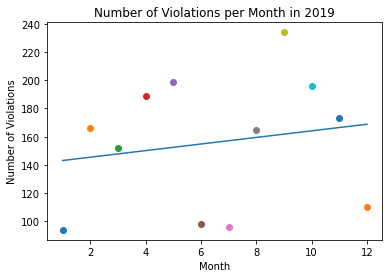

In [12]:
# Reshapes the arrays to run a linear regression on them
x19 = np.array(count19['Month']).reshape(-1,1)
y19 = np.array(count19['Num_Of_Violations']).reshape(-1,1)

# We use SkLearn to run a linear regression based off of the data in 2019 that we just gathered
reg19 = sk.linear_model.LinearRegression().fit(x19, y19)

# Plots the linear regression and the number of violations per month in 2019, as well as adding relevant graph info
plt.plot(x19, reg19.predict(x19))
plt.title('Number of Violations per Month in 2019')
plt.xlabel('Month')
plt.ylabel('Number of Violations')
for i, row in count19.iterrows():
    plt.scatter(row['Month'], row['Num_Of_Violations'])
plt.show()

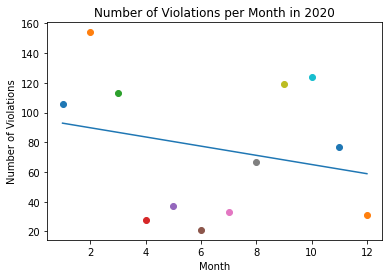

In [13]:
# Reshapes the arrays to run a linear regression on them
x20 = np.array(count20['Month']).reshape(-1,1)
y20 = np.array(count20['Num_Of_Violations']).reshape(-1,1)

# We use SkLearn to run a linear regression based off of the data in 2020 that we just gathered
reg20 = sk.linear_model.LinearRegression().fit(x20, y20)

# Plots the linear regression and the number of violations per month in 2020, as well as adding relevant graph info
plt.plot(x20, reg20.predict(x20))
plt.title('Number of Violations per Month in 2020')
plt.xlabel('Month')
plt.ylabel('Number of Violations')
for i, row in count20.iterrows():
    plt.scatter(row['Month'], row['Num_Of_Violations'])
plt.show()

After looking at the plot of violations per months for 2019 and 2020, we see that the number of violations per month incrases in 2019 (as seen in the linear regression in 2019) and the number of violations per month in 2020 decreases (as seen in the linear regression of 2020).

Continuing, we'll run a t-test based off the values of the linear regression from 2019 and 2020 and see if we reject or fail to reject the null hypothesis.

In [14]:
# We grab predicted values based off of our x values (months) from the linear regression 
# to see how accurate our linear regression is for 2019 and 2020 values, respectively.
predict19 = reg19.predict(x19)
predict20 = reg20.predict(x20)

# Run ttests based off of our real y values and predicted y values for each year
# then for the predicted 2019 and predicted 2020 values and real y values for 2019 and 2020
t1 = ttest_rel(predict19, y19)
t2 = ttest_rel(predict20, y20)
t3 = ttest_rel(predict19, predict20)
t4 = ttest_rel(y19, y20)

print(t1)
print(t2)
print(t3)
print(t4)

Ttest_relResult(statistic=array([1.07072527e-15]), pvalue=array([1.]))
Ttest_relResult(statistic=array([-1.01028991e-15]), pvalue=array([1.]))
Ttest_relResult(statistic=array([14.19342114]), pvalue=array([2.03626743e-08]))
Ttest_relResult(statistic=array([5.2981175]), pvalue=array([0.00025314]))


As we can see from the t-test results, the linear regression for 2019 works really well as the t value is extremely close to 0. The samse also occurs in 2020. Both of the first p-values are 1 meaning our linear regressions work really well with our data sets.

The last t-test compares the values in 2019 and 2020. As we can see, our t value is high at 14.19 with our p-value being really close to 0. Thus we fail to reject the null hypothesis, as our p-value is extremely low, we reject the null hypothesis as there is enough evidence to link the COVID-19 pandemic with a lower crime rate. Furthermore, we can confirm this with our real data as our pvalue is 0.00025 for a t value of 5.298.